## Import Needed Libraries

In [1]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
import joblib
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## Read Data

In [2]:
data_dir='/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'
target_folder='ALL'
filepath=[]
labels=[]
all_folder_path = os.path.join(data_dir, target_folder)

if os.path.isdir(all_folder_path):
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)
        fipath=os.listdir(fpath)
        for image in fipath:
            path = os.path.join(fpath, image)
            filepath.append(path)
            labels.append(f)  

f_series = pd.Series(filepath, name='filepath')
l_series = pd.Series(labels, name='labels')
df = pd.concat([f_series, l_series], axis=1)

In [3]:
df.head()

,filepath,labels
0,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,all_pro
1,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,all_pro
2,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,all_pro
3,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,all_pro
4,/kaggle/input/multi-cancer/Multi Cancer/Multi ...,all_pro


## visulization

In [4]:
count=df['labels'].value_counts().reset_index()
count.columns=['labels','count']
count_fig=px.bar(count,x='labels',y='count',title='count of labels',text_auto=True)
count_fig.show()

## split Data

In [5]:
strat=df['labels']
train_df ,dummy_df=train_test_split(df,test_size=0.3,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [6]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(14000, 2)
(3000, 2)
(3000, 2)


In [7]:
count_train=train_df['labels'].value_counts().reset_index()
count_train.columns=['labels','count']
count=px.bar(count_train,x='labels',y='count',title='count of labels per train_df',text_auto=True)
count.show()

In [8]:
count_valid=valid_df['labels'].value_counts().reset_index()
count_valid.columns=['labels','count']
fig=px.bar(count_valid,x='labels',y='count',title='count of labels per valid_df',text_auto=True)
fig.show()

In [9]:
count_test=test_df['labels'].value_counts().reset_index()
count_test.columns=['labels','count']
fig=px.bar(count_test,x='labels',y='count',title='count of labels per test_df',text_auto=True)
fig.show()

## Data Augmentation

In [10]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 14000 validated image filenames belonging to 4 classes.
Found 3000 validated image filenames belonging to 4 classes.
Found 3000 validated image filenames belonging to 4 classes.


## sample of Data

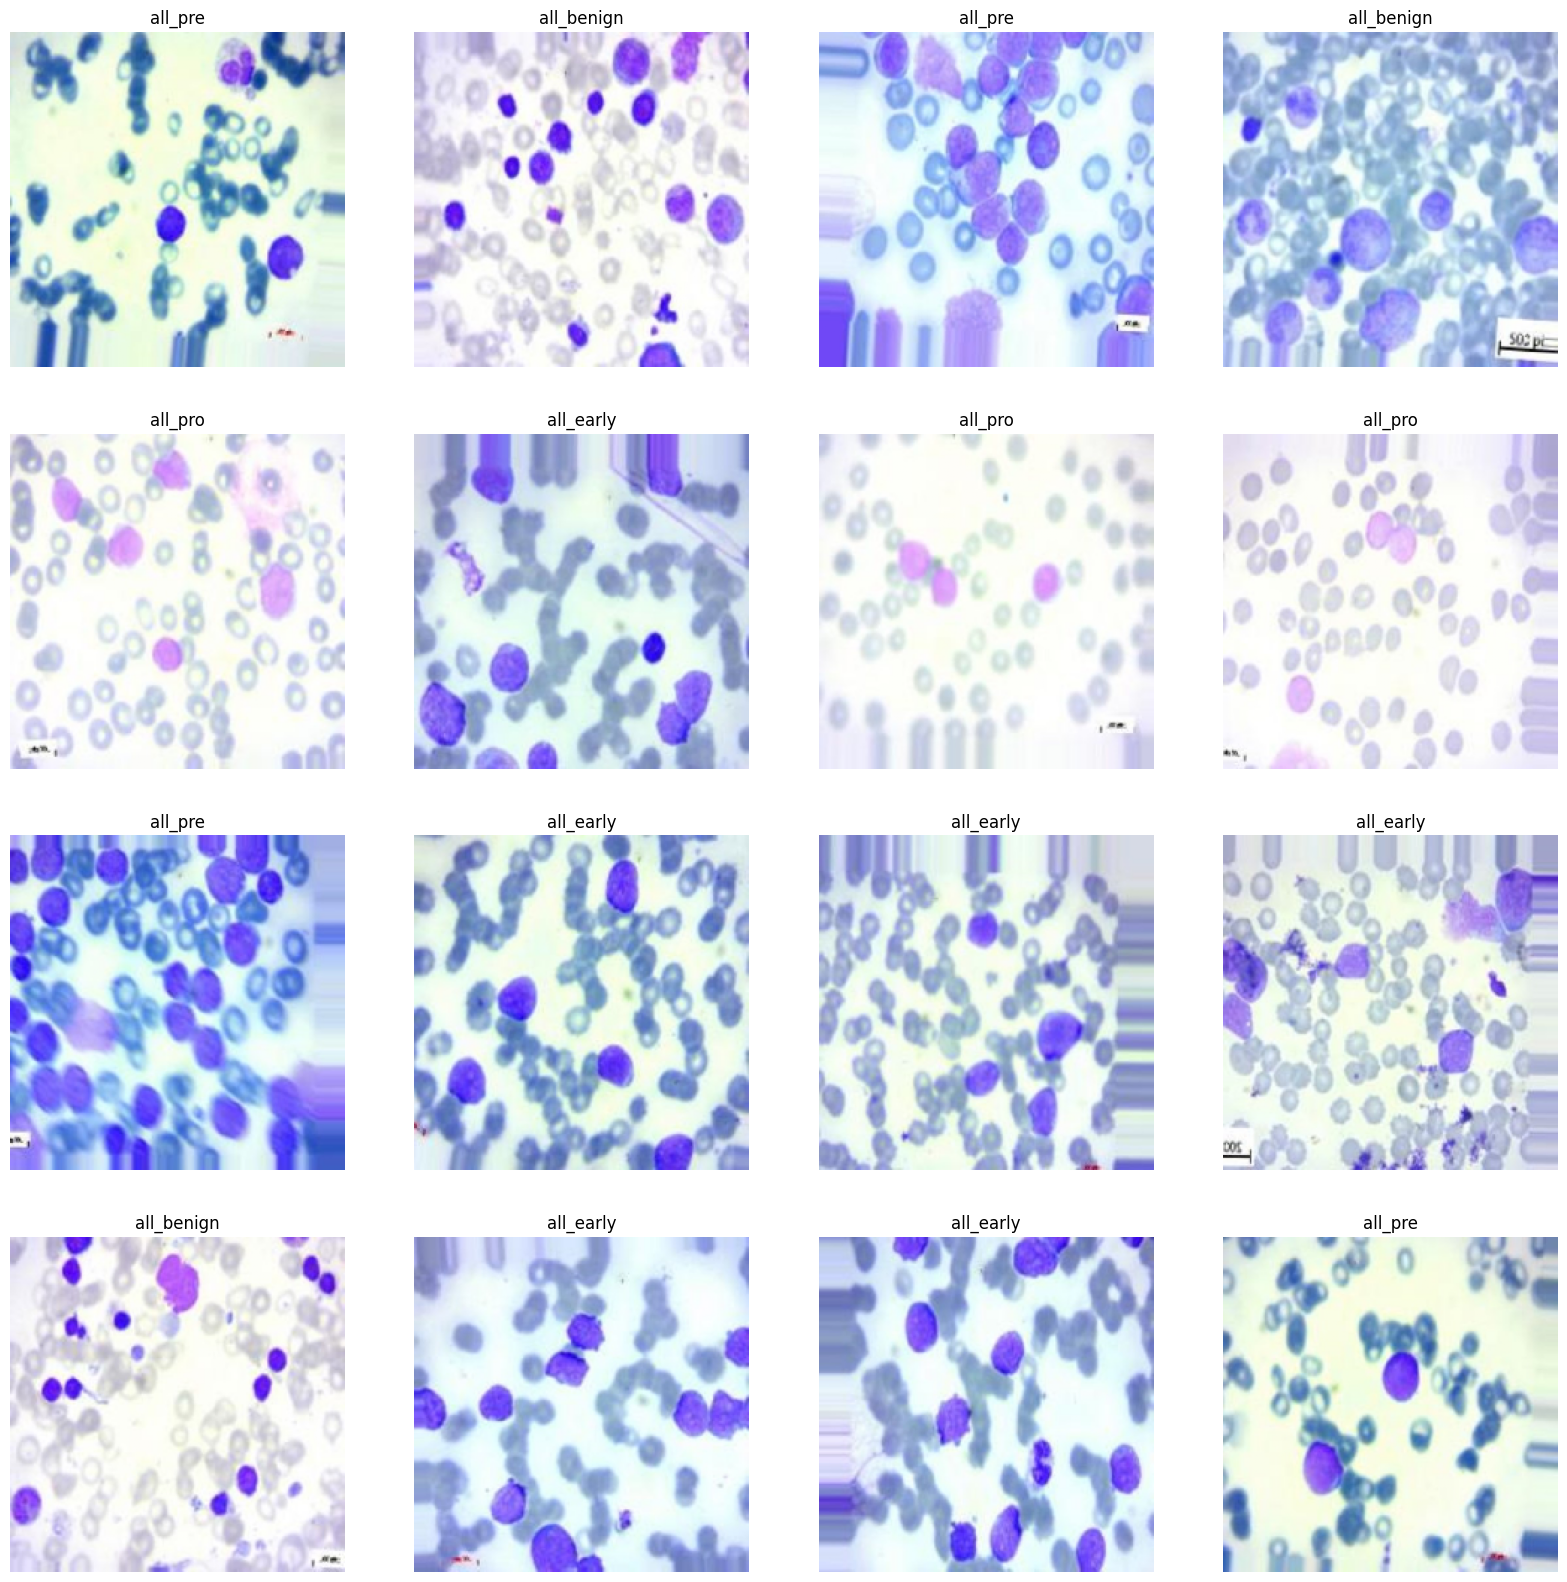

In [11]:
g_dict = train_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(train_gen)     

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

## Bulid model

In [12]:
base_model=keras.applications.EfficientNetB0(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(64,activation='relu'),
    Dense(4,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history=model.fit(train_gen,epochs=100,validation_data=valid_gen,shuffle=False,
                  callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1729957505.798550      70 service.cc:145] XLA service 0x7e3320039330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729957505.798610      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729957554.945015      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 253s 779ms/step - accuracy: 0.9454 - loss: 0.1779 - val_accuracy: 0.9683 - val_loss: 0.1062
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 263ms/step - accuracy: 0.9989 - loss: 0.0032 - val_accuracy: 0.9997 - val_loss: 4.1889e-04
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 57s 259ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9997 - val_loss: 0.0021
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 264ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 57s 261ms/step - accuracy: 0.9999 - loss: 7.5432e-04 - val_accuracy: 1.0000 - val_loss: 1.3395e-05
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 59s 267ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.9997 - val_loss: 7.3795e-04
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 59s 267ms/step - accuracy: 0.9987 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 1.7599e-04
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 263ms/step - accuracy:

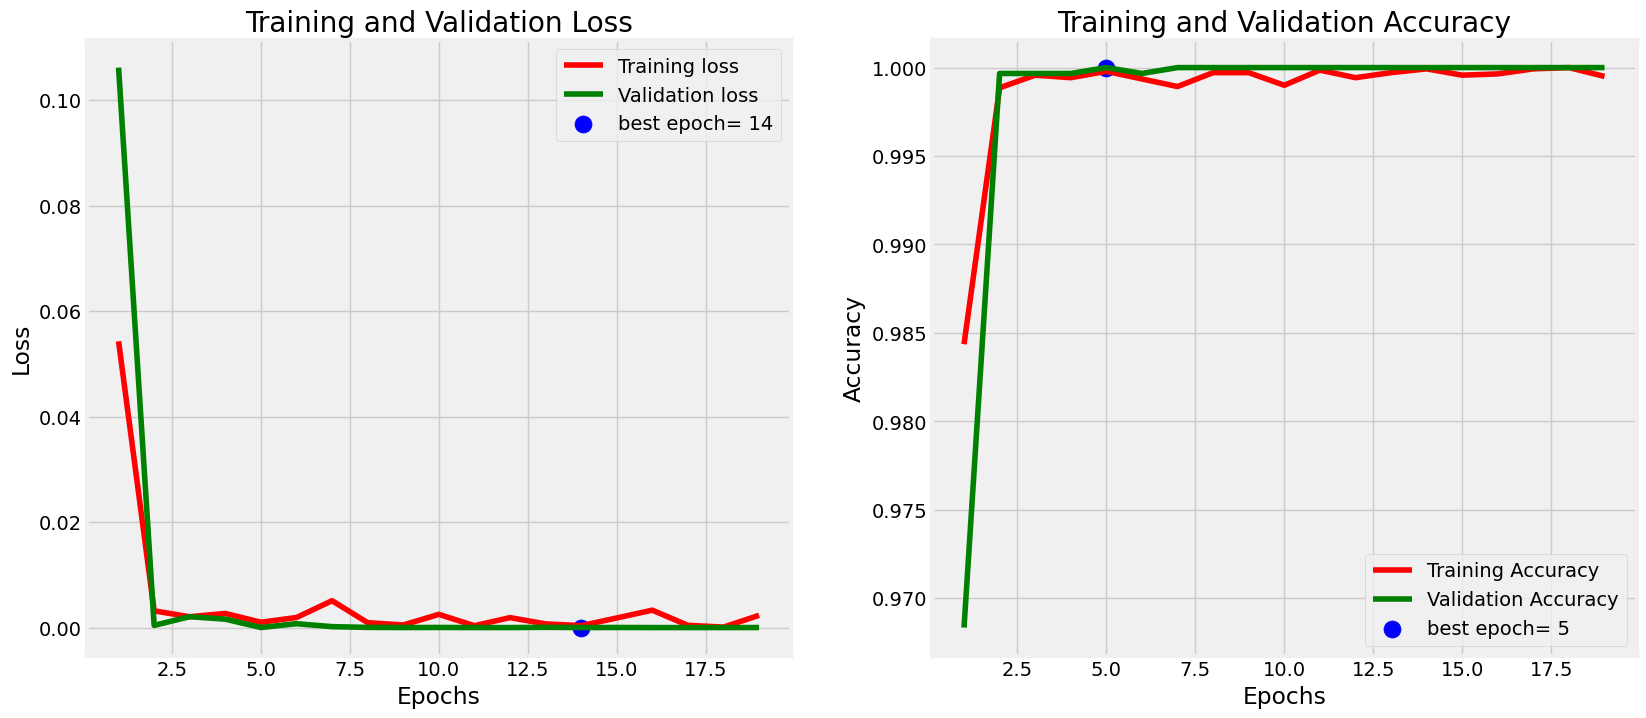

In [14]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Evalution

In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 1.0000 - loss: 1.7878e-09
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 1.0000 - loss: 1.2622e-08
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 430ms/step - accuracy: 1.0000 - loss: 3.7343e-08
Train Loss:  3.4458875752818585e-09
Train Accuracy:  1.0
--------------------
Valid Loss:  2.0814935552948555e-08
Valid Accuracy:  1.0
--------------------
Test Loss:  4.3351747081032954e-08
Test Accuracy:  1.0


In [16]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step


## confusion matrix

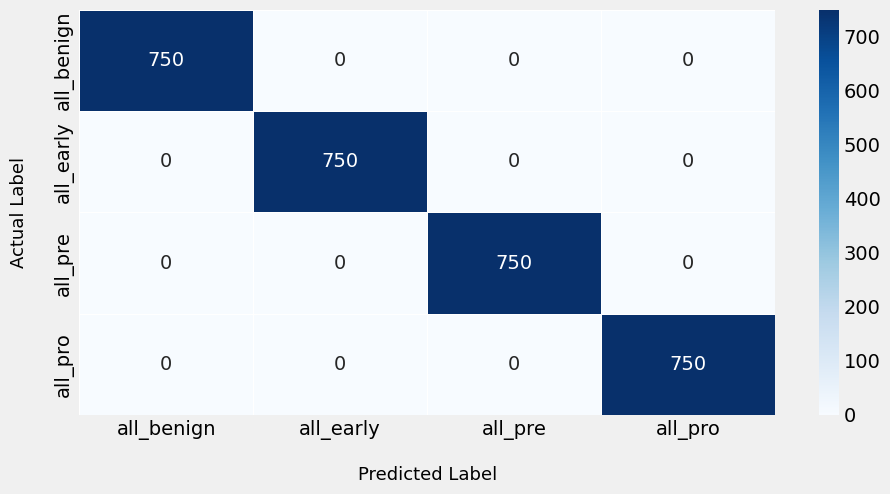

In [17]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

## classification Report

In [18]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

  all_benign       1.00      1.00      1.00       750
   all_early       1.00      1.00      1.00       750
     all_pre       1.00      1.00      1.00       750
     all_pro       1.00      1.00      1.00       750

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



## save model

In [19]:
joblib.dump(model,"Acute Lymphoblastic Leukemia classification.pkl")

['Acute Lymphoblastic Leukemia classification.pkl']